In [2]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [4]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = ToTensor(),
    download = True
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = ToTensor(),
    download = True
)

Using downloaded and verified file: data/MNIST/raw/train-images-idx3-ubyte.gz
Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Using downloaded and verified file: data/MNIST/raw/train-labels-idx1-ubyte.gz
Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Using downloaded and verified file: data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 6726881.63it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [5]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [8]:
train_data.data

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        ...,

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0,

In [9]:
train_data.targets.size()

torch.Size([60000])

In [10]:
train_data.targets

tensor([5, 0, 4,  ..., 5, 6, 8])

In [11]:
from torch.utils.data import DataLoader
loaders = {
    'train': DataLoader(train_data, batch_size=100, shuffle=True, num_workers=1),
    'test': DataLoader(test_data, batch_size=100, shuffle=True, num_workers=1)
}

In [12]:
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x15e6a48d0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x15e6a6750>}

In [13]:
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim

class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        # Convolutional Layer
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()

        # Fully Connected Layer, 10 outputs for 10 digits
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        # Now reshape the data
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)

        return F.softmax(x)

In [23]:
import torch

device = torch.device('cude' if torch.cuda.is_available() else 'cpu')

model = CNN().to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

loss_fn = nn.CrossEntropyLoss()

def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loaders['train']):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        # Get output from the model
        output = model(data)
        # Calculate loss
        loss = loss_fn(output, target)
        # Backpropagation
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loaders['train'].dataset),
                100. * batch_idx / len(loaders['train']), loss.item()))
            
def test():
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for data, target in loaders['test']:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += loss_fn(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    
    test_loss /= len(loaders['test'].dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy {correct}/{len(loaders["test"].dataset)} ({100. * correct / len(loaders["test"].dataset):.0f}%)\n')


In [24]:
for epoch in range(1, 11):
    train(epoch)
    test()

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.
/var/folders/8_/zwdgvq8s7sg2krgqt5kmw5br0000gn/T/ipykernel_55690/772288725.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301122
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.291342
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.252569
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.033318
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.960463
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.840258
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.793065
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.826111
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.764515
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.762551
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.745879
Train Epoch: 1 [22000/60000 (37%)]	Loss: 1.660256
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.622873
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.727036
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.688785
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.674856
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.653031
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.639920
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.611534
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.639712
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0153, Accuracy 9359/10000 (94%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 2 [0/60000 (0%)]	Loss: 1.586815
Train Epoch: 2 [2000/60000 (3%)]	Loss: 1.593674
Train Epoch: 2 [4000/60000 (7%)]	Loss: 1.610916
Train Epoch: 2 [6000/60000 (10%)]	Loss: 1.573946
Train Epoch: 2 [8000/60000 (13%)]	Loss: 1.583460
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.557602
Train Epoch: 2 [12000/60000 (20%)]	Loss: 1.566439
Train Epoch: 2 [14000/60000 (23%)]	Loss: 1.594279
Train Epoch: 2 [16000/60000 (27%)]	Loss: 1.553740
Train Epoch: 2 [18000/60000 (30%)]	Loss: 1.582371
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.535748
Train Epoch: 2 [22000/60000 (37%)]	Loss: 1.541762
Train Epoch: 2 [24000/60000 (40%)]	Loss: 1.572188
Train Epoch: 2 [26000/60000 (43%)]	Loss: 1.577557
Train Epoch: 2 [28000/60000 (47%)]	Loss: 1.541634
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.569324
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.570668
Train Epoch: 2 [34000/60000 (57%)]	Loss: 1.596623
Train Epoch: 2 [36000/60000 (60%)]	Loss: 1.541718
Train Epoch: 2 [38000/60000 (63%)]	Loss: 1.639834
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0151, Accuracy 9521/10000 (95%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 3 [0/60000 (0%)]	Loss: 1.582371
Train Epoch: 3 [2000/60000 (3%)]	Loss: 1.563848
Train Epoch: 3 [4000/60000 (7%)]	Loss: 1.542845
Train Epoch: 3 [6000/60000 (10%)]	Loss: 1.554214
Train Epoch: 3 [8000/60000 (13%)]	Loss: 1.624883
Train Epoch: 3 [10000/60000 (17%)]	Loss: 1.570241
Train Epoch: 3 [12000/60000 (20%)]	Loss: 1.554696
Train Epoch: 3 [14000/60000 (23%)]	Loss: 1.545573
Train Epoch: 3 [16000/60000 (27%)]	Loss: 1.557140
Train Epoch: 3 [18000/60000 (30%)]	Loss: 1.549617
Train Epoch: 3 [20000/60000 (33%)]	Loss: 1.572024
Train Epoch: 3 [22000/60000 (37%)]	Loss: 1.556338
Train Epoch: 3 [24000/60000 (40%)]	Loss: 1.576735
Train Epoch: 3 [26000/60000 (43%)]	Loss: 1.533066
Train Epoch: 3 [28000/60000 (47%)]	Loss: 1.541559
Train Epoch: 3 [30000/60000 (50%)]	Loss: 1.574289
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.543016
Train Epoch: 3 [34000/60000 (57%)]	Loss: 1.511618
Train Epoch: 3 [36000/60000 (60%)]	Loss: 1.536836
Train Epoch: 3 [38000/60000 (63%)]	Loss: 1.539863
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0150, Accuracy 9605/10000 (96%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 4 [0/60000 (0%)]	Loss: 1.564411
Train Epoch: 4 [2000/60000 (3%)]	Loss: 1.537811
Train Epoch: 4 [4000/60000 (7%)]	Loss: 1.546389
Train Epoch: 4 [6000/60000 (10%)]	Loss: 1.563647
Train Epoch: 4 [8000/60000 (13%)]	Loss: 1.524637
Train Epoch: 4 [10000/60000 (17%)]	Loss: 1.551088
Train Epoch: 4 [12000/60000 (20%)]	Loss: 1.552058
Train Epoch: 4 [14000/60000 (23%)]	Loss: 1.492138
Train Epoch: 4 [16000/60000 (27%)]	Loss: 1.538976
Train Epoch: 4 [18000/60000 (30%)]	Loss: 1.548308
Train Epoch: 4 [20000/60000 (33%)]	Loss: 1.585660
Train Epoch: 4 [22000/60000 (37%)]	Loss: 1.542507
Train Epoch: 4 [24000/60000 (40%)]	Loss: 1.576112
Train Epoch: 4 [26000/60000 (43%)]	Loss: 1.577055
Train Epoch: 4 [28000/60000 (47%)]	Loss: 1.530329
Train Epoch: 4 [30000/60000 (50%)]	Loss: 1.573539
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.544305
Train Epoch: 4 [34000/60000 (57%)]	Loss: 1.524215
Train Epoch: 4 [36000/60000 (60%)]	Loss: 1.524931
Train Epoch: 4 [38000/60000 (63%)]	Loss: 1.515917
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0150, Accuracy 9617/10000 (96%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 5 [0/60000 (0%)]	Loss: 1.575808
Train Epoch: 5 [2000/60000 (3%)]	Loss: 1.572318
Train Epoch: 5 [4000/60000 (7%)]	Loss: 1.579865
Train Epoch: 5 [6000/60000 (10%)]	Loss: 1.541441
Train Epoch: 5 [8000/60000 (13%)]	Loss: 1.521828
Train Epoch: 5 [10000/60000 (17%)]	Loss: 1.561922
Train Epoch: 5 [12000/60000 (20%)]	Loss: 1.549809
Train Epoch: 5 [14000/60000 (23%)]	Loss: 1.506010
Train Epoch: 5 [16000/60000 (27%)]	Loss: 1.537122
Train Epoch: 5 [18000/60000 (30%)]	Loss: 1.574282
Train Epoch: 5 [20000/60000 (33%)]	Loss: 1.549763
Train Epoch: 5 [22000/60000 (37%)]	Loss: 1.555355
Train Epoch: 5 [24000/60000 (40%)]	Loss: 1.474074
Train Epoch: 5 [26000/60000 (43%)]	Loss: 1.529290
Train Epoch: 5 [28000/60000 (47%)]	Loss: 1.531533
Train Epoch: 5 [30000/60000 (50%)]	Loss: 1.496386
Train Epoch: 5 [32000/60000 (53%)]	Loss: 1.519618
Train Epoch: 5 [34000/60000 (57%)]	Loss: 1.524159
Train Epoch: 5 [36000/60000 (60%)]	Loss: 1.500501
Train Epoch: 5 [38000/60000 (63%)]	Loss: 1.550372
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0150, Accuracy 9656/10000 (97%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 6 [0/60000 (0%)]	Loss: 1.510708
Train Epoch: 6 [2000/60000 (3%)]	Loss: 1.588737
Train Epoch: 6 [4000/60000 (7%)]	Loss: 1.530821
Train Epoch: 6 [6000/60000 (10%)]	Loss: 1.503227
Train Epoch: 6 [8000/60000 (13%)]	Loss: 1.569412
Train Epoch: 6 [10000/60000 (17%)]	Loss: 1.578902
Train Epoch: 6 [12000/60000 (20%)]	Loss: 1.498904
Train Epoch: 6 [14000/60000 (23%)]	Loss: 1.562650
Train Epoch: 6 [16000/60000 (27%)]	Loss: 1.535777
Train Epoch: 6 [18000/60000 (30%)]	Loss: 1.548182
Train Epoch: 6 [20000/60000 (33%)]	Loss: 1.545981
Train Epoch: 6 [22000/60000 (37%)]	Loss: 1.546035
Train Epoch: 6 [24000/60000 (40%)]	Loss: 1.552134
Train Epoch: 6 [26000/60000 (43%)]	Loss: 1.514127
Train Epoch: 6 [28000/60000 (47%)]	Loss: 1.547321
Train Epoch: 6 [30000/60000 (50%)]	Loss: 1.518097
Train Epoch: 6 [32000/60000 (53%)]	Loss: 1.492762
Train Epoch: 6 [34000/60000 (57%)]	Loss: 1.539465
Train Epoch: 6 [36000/60000 (60%)]	Loss: 1.531493
Train Epoch: 6 [38000/60000 (63%)]	Loss: 1.543103
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0150, Accuracy 9654/10000 (97%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 7 [0/60000 (0%)]	Loss: 1.545335
Train Epoch: 7 [2000/60000 (3%)]	Loss: 1.555209
Train Epoch: 7 [4000/60000 (7%)]	Loss: 1.554775
Train Epoch: 7 [6000/60000 (10%)]	Loss: 1.516811
Train Epoch: 7 [8000/60000 (13%)]	Loss: 1.485572
Train Epoch: 7 [10000/60000 (17%)]	Loss: 1.517354
Train Epoch: 7 [12000/60000 (20%)]	Loss: 1.513165
Train Epoch: 7 [14000/60000 (23%)]	Loss: 1.551302
Train Epoch: 7 [16000/60000 (27%)]	Loss: 1.529254
Train Epoch: 7 [18000/60000 (30%)]	Loss: 1.548886
Train Epoch: 7 [20000/60000 (33%)]	Loss: 1.553564
Train Epoch: 7 [22000/60000 (37%)]	Loss: 1.546191
Train Epoch: 7 [24000/60000 (40%)]	Loss: 1.519066
Train Epoch: 7 [26000/60000 (43%)]	Loss: 1.496220
Train Epoch: 7 [28000/60000 (47%)]	Loss: 1.552546
Train Epoch: 7 [30000/60000 (50%)]	Loss: 1.525354
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.563036
Train Epoch: 7 [34000/60000 (57%)]	Loss: 1.562620
Train Epoch: 7 [36000/60000 (60%)]	Loss: 1.526513
Train Epoch: 7 [38000/60000 (63%)]	Loss: 1.506568
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0149, Accuracy 9708/10000 (97%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 8 [0/60000 (0%)]	Loss: 1.538054
Train Epoch: 8 [2000/60000 (3%)]	Loss: 1.534328
Train Epoch: 8 [4000/60000 (7%)]	Loss: 1.512790
Train Epoch: 8 [6000/60000 (10%)]	Loss: 1.530320
Train Epoch: 8 [8000/60000 (13%)]	Loss: 1.550302
Train Epoch: 8 [10000/60000 (17%)]	Loss: 1.491084
Train Epoch: 8 [12000/60000 (20%)]	Loss: 1.506752
Train Epoch: 8 [14000/60000 (23%)]	Loss: 1.566517
Train Epoch: 8 [16000/60000 (27%)]	Loss: 1.553064
Train Epoch: 8 [18000/60000 (30%)]	Loss: 1.534902
Train Epoch: 8 [20000/60000 (33%)]	Loss: 1.495860
Train Epoch: 8 [22000/60000 (37%)]	Loss: 1.591371
Train Epoch: 8 [24000/60000 (40%)]	Loss: 1.536888
Train Epoch: 8 [26000/60000 (43%)]	Loss: 1.586296
Train Epoch: 8 [28000/60000 (47%)]	Loss: 1.501801
Train Epoch: 8 [30000/60000 (50%)]	Loss: 1.524825
Train Epoch: 8 [32000/60000 (53%)]	Loss: 1.533366
Train Epoch: 8 [34000/60000 (57%)]	Loss: 1.525098
Train Epoch: 8 [36000/60000 (60%)]	Loss: 1.518793
Train Epoch: 8 [38000/60000 (63%)]	Loss: 1.509668
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0149, Accuracy 9720/10000 (97%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 9 [0/60000 (0%)]	Loss: 1.526721
Train Epoch: 9 [2000/60000 (3%)]	Loss: 1.514489
Train Epoch: 9 [4000/60000 (7%)]	Loss: 1.524985
Train Epoch: 9 [6000/60000 (10%)]	Loss: 1.537595
Train Epoch: 9 [8000/60000 (13%)]	Loss: 1.513435
Train Epoch: 9 [10000/60000 (17%)]	Loss: 1.540795
Train Epoch: 9 [12000/60000 (20%)]	Loss: 1.520660
Train Epoch: 9 [14000/60000 (23%)]	Loss: 1.538409
Train Epoch: 9 [16000/60000 (27%)]	Loss: 1.583185
Train Epoch: 9 [18000/60000 (30%)]	Loss: 1.500991
Train Epoch: 9 [20000/60000 (33%)]	Loss: 1.538952
Train Epoch: 9 [22000/60000 (37%)]	Loss: 1.526661
Train Epoch: 9 [24000/60000 (40%)]	Loss: 1.528756
Train Epoch: 9 [26000/60000 (43%)]	Loss: 1.494189
Train Epoch: 9 [28000/60000 (47%)]	Loss: 1.521549
Train Epoch: 9 [30000/60000 (50%)]	Loss: 1.533153
Train Epoch: 9 [32000/60000 (53%)]	Loss: 1.557878
Train Epoch: 9 [34000/60000 (57%)]	Loss: 1.536547
Train Epoch: 9 [36000/60000 (60%)]	Loss: 1.550984
Train Epoch: 9 [38000/60000 (63%)]	Loss: 1.492613
Train Epoch

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0149, Accuracy 9732/10000 (97%)



0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.


Train Epoch: 10 [0/60000 (0%)]	Loss: 1.522892
Train Epoch: 10 [2000/60000 (3%)]	Loss: 1.493500
Train Epoch: 10 [4000/60000 (7%)]	Loss: 1.514041
Train Epoch: 10 [6000/60000 (10%)]	Loss: 1.514003
Train Epoch: 10 [8000/60000 (13%)]	Loss: 1.536358
Train Epoch: 10 [10000/60000 (17%)]	Loss: 1.488125
Train Epoch: 10 [12000/60000 (20%)]	Loss: 1.551532
Train Epoch: 10 [14000/60000 (23%)]	Loss: 1.523754
Train Epoch: 10 [16000/60000 (27%)]	Loss: 1.530546
Train Epoch: 10 [18000/60000 (30%)]	Loss: 1.531755
Train Epoch: 10 [20000/60000 (33%)]	Loss: 1.516042
Train Epoch: 10 [22000/60000 (37%)]	Loss: 1.548903
Train Epoch: 10 [24000/60000 (40%)]	Loss: 1.517041
Train Epoch: 10 [26000/60000 (43%)]	Loss: 1.504199
Train Epoch: 10 [28000/60000 (47%)]	Loss: 1.533267
Train Epoch: 10 [30000/60000 (50%)]	Loss: 1.543018
Train Epoch: 10 [32000/60000 (53%)]	Loss: 1.549213
Train Epoch: 10 [34000/60000 (57%)]	Loss: 1.553700
Train Epoch: 10 [36000/60000 (60%)]	Loss: 1.541805
Train Epoch: 10 [38000/60000 (63%)]	Loss: 

0.00s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfrozen_modules=off
0.00s - to python to disable frozen modules.
0.00s - Note: Debugging will proceed. Set PYDEVD_DISABLE_FILE_VALIDATION=1 to disable this validation.



Test set: Average loss: 0.0149, Accuracy 9735/10000 (97%)



Prediction: 1


/var/folders/8_/zwdgvq8s7sg2krgqt5kmw5br0000gn/T/ipykernel_55690/772288725.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


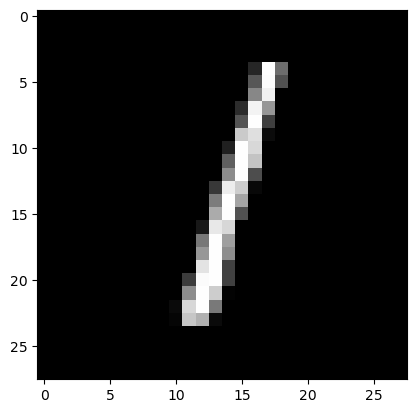

In [26]:
import matplotlib.pyplot as plt

model.eval()

data, target = test_data[2]

data = data.unsqueeze(0).to(device)

output = model(data)

prediction = output.argmax(dim=1, keepdim=True).item()

print(f'Prediction: {prediction}')

image = data.squeeze(0).squeeze(0).cpu().numpy()

plt.imshow(image, cmap='gray')
plt.show()